# Airline Tweet Sentiment Analysis Using Unsupervised Methods

This is an old dataset from 2015. It is available now on [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv) though the original source now seems to be defunct. It is a collection of tweets directed at various US airlines. The tweets have been labeled according to their sentiment.

For this project, we will compare the performance on this dataset of three unsupervised methods: NMF, Kmeans, and Expectation-Maximization.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time

'''
# only needed if converting text (Part 1b)

import re

# only needed if lemmatizing is desired (Part 1b)

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
'''
from itertools import permutations
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# 1) EDA, Cleaning, & Preparation

In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We are mostly interested in the *text* of the tweets themselves, rather than the metadata, however it is worth seeing what is available.

In [3]:
#Check number of unique values in each feature
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

> Takeaways: 
> 
> - *airline_sentiment_confidence* may suggest inclusion/exclusion in dataset; shouldn't be included in features
> - *negativereason* shouldn't be included in features
> - unclear what *airline_sentiment_gold* and *negativereason_gold* might be; unlikely to appropriate for inclusion
> - *name* is unlikely to be useful
> - *text* has 14247 uniques vs 14485 total, suggesting duplicates and/or *NaN* values
> - *tweet_coord*, *tweet_created*, *tweet_location*, *user_timezone* may be interesting, but likely unnecessary or inappropriate for inclusion as features. Given the 85 unique timezones, some cleaning must be required (there should only be 24 I believe, maybe double if DST is factored in, but certainly <85).

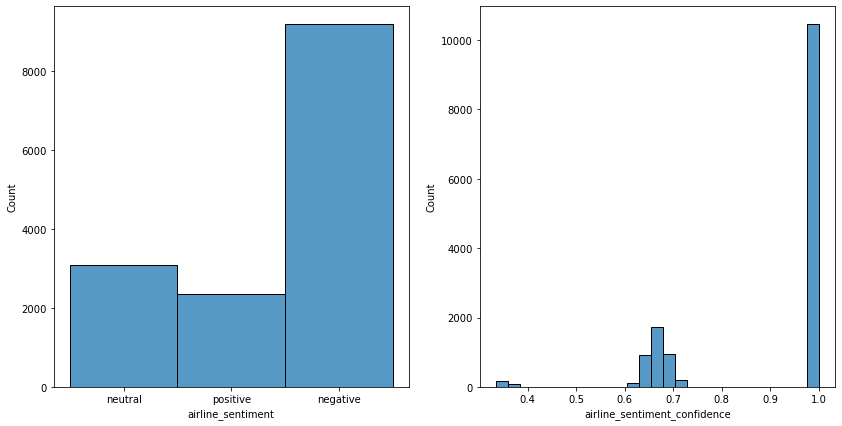

In [4]:
# First investigate primary series of interest: airline_sentiment
# also, look at airline_sentiment_confidence
fig, axs = plt.subplots(1,2, figsize=(14,7))
sns.histplot(df.airline_sentiment, ax=axs[0])
sns.histplot(df.airline_sentiment_confidence, ax=axs[1])
plt.show()

> - We have a class imbalance that we should keep in mind.
> - The vast majority of labels have a confidence of 1.0.

In [5]:
# remove tweets with sentiment confidence below 1.0 (no sense in training or evaluating with unrealiable labels)
df_lim = df[df.airline_sentiment_confidence==1]
df_lim.shape

(10445, 15)

In [6]:
# Remove duplicate 
df_lim = df_lim[df_lim.text.duplicated()==False]

In [7]:
df_lim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10344 entries, 0 to 14638
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      10344 non-null  int64  
 1   airline_sentiment             10344 non-null  object 
 2   airline_sentiment_confidence  10344 non-null  float64
 3   negativereason                7317 non-null   object 
 4   negativereason_confidence     7317 non-null   float64
 5   airline                       10344 non-null  object 
 6   airline_sentiment_gold        23 non-null     object 
 7   name                          10344 non-null  object 
 8   negativereason_gold           20 non-null     object 
 9   retweet_count                 10344 non-null  int64  
 10  text                          10344 non-null  object 
 11  tweet_coord                   734 non-null    object 
 12  tweet_created                 10344 non-null  object 
 13  t

> 10,000+ tweets remaining

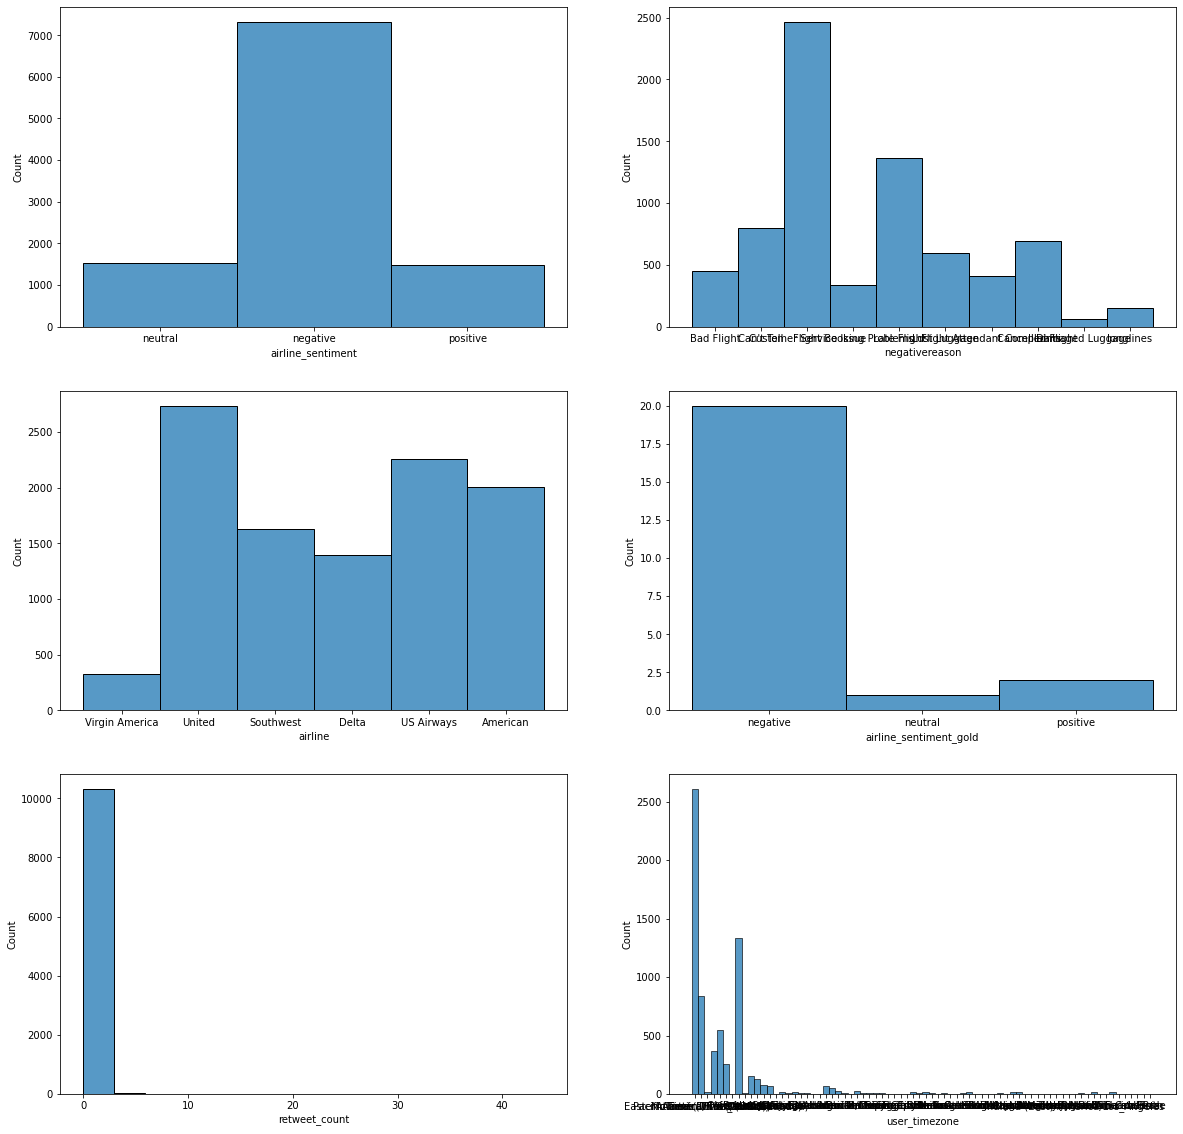

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
sns.histplot(df_lim.airline_sentiment, ax=axs[0, 0])
sns.histplot(df_lim.negativereason, ax=axs[0, 1])
sns.histplot(df_lim.airline, ax=axs[1, 0])
sns.histplot(df_lim.airline_sentiment_gold, ax=axs[1, 1])
sns.histplot(df_lim.retweet_count, ax=axs[2, 0])
sns.histplot(df_lim.user_timezone, ax=axs[2, 1])
plt.show()

> - *airline_sentiment* appears to be balanced in a roughly similar fashion
> - Nothing interesting stands out for *negativereason*, *airline*, and *user_timezone*
> - It's unclear what *airline_sentiment_gold* represents, but the distribution is similar to the original sentiment
> - The timezones with high counts likely represent ones corresponding to the US.

In [9]:
df_lim.retweet_count.value_counts()

0     9723
1      529
2       50
3       17
4       12
5        4
6        2
22       1
31       1
11       1
8        1
9        1
32       1
44       1
Name: retweet_count, dtype: int64

> It's very clear that most tweets have zero retweets. If we include this as a feature, it may be better to include it as a binary value ("retweeted"). We will leave it out for now, and revisit it if needed.

Let's move on to looking at the tweets themselves

In [10]:
df_lim.text.isnull().sum()

0

In [11]:
print(*(df_lim.text.iloc[i] for i in range(0,500,100)), sep='\n')

@VirginAmerica What @dhepburn said.
@virginamerica #flight home to #dc #sunset #globe in' #backtowinter back to #work! #refreshed http://t.co/VX9vBCTdLf
@VirginAmerica Results Handily Exceed Forecasts - @NYTimes http://t.co/gonmRwEM6I
@VirginAmerica I love the dancing little richard. cool beans.
@united does this process ever end? Still waiting for the reply since 2 months #pathetic #customerservice


> The tweets don't appear to been cleaned. The tweets include special symbols, including those for hashtags and @mentions. They also include capitalization and links.

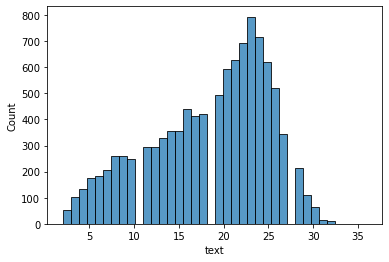

In [12]:
word_count = df_lim.text.str.split().apply(len)
sns.histplot(word_count)
plt.show()

> As expected (due to the platform's character limits), there is a hard limit to the length of the tweets.

### 1b) Prepare Text

NOTE: The options explored in this section **reduced** the **performance** of the methods explored later, so will be skipped.

The text vectorizer we will use later includes some text cleaning features, including converting text to lowercase and removing stop words, so we don't need to worry about those here.

Some option we could use are:
- @mentions: removing @mentions entirely; reducing entire @mention to @; leaving as is (selected)
- punctuation: removing ALL punctuations; leaving in hashtags, periods, commas; leaving as is (selected)
- lemmatization: converting verbs and nouns; leaving as is (selected)

Again, the less I cleaned the text, the better the model performed, so this section will be commented out.

In [13]:
'''
df_cln = df_lim.text.copy()

for i in range(len(df_lim.text)):
    # remove @mentions
    df_cln.iloc[i] = re.sub("@\S+", "@", df_cln.iloc[i])
    # remove punctuation (Except #, @, and commas)
    df_cln.iloc[i] = re.sub(r'[^.,#@\w\s]', '', df_cln.iloc[i])
    # lemmatize words
    df_cln.iloc[i] = ' '.join([WordNetLemmatizer().lemmatize(w) for w in nltk.word_tokenize(df_cln.iloc[i])])
'''

'\ndf_cln = df_lim.text.copy()\n\nfor i in range(len(df_lim.text)):\n    # remove @mentions\n    df_cln.iloc[i] = re.sub("@\\S+", "@", df_cln.iloc[i])\n    # remove punctuation (Except #, @, and commas)\n    df_cln.iloc[i] = re.sub(r\'[^.,#@\\w\\s]\', \'\', df_cln.iloc[i])\n    # lemmatize words\n    df_cln.iloc[i] = \' \'.join([WordNetLemmatizer().lemmatize(w) for w in nltk.word_tokenize(df_cln.iloc[i])])\n'

### 1c) Train/Val/Test Split

In [14]:
# Split df into 6 for training, validation, and test for features and labels

split_size = int(df.shape[0]*0.2)

# split out test set, leave rest as "non_test"
non_test, tst, ynon_test, ytst = train_test_split(df_lim.text, 
                                                  df_lim.airline_sentiment,
                                                  test_size = split_size,
                                                  random_state = 7,
                                                  stratify=df_lim.airline_sentiment)

# split tmp into training and validation sets
trn, vld, ytrn, yvld = train_test_split(non_test,
                                        ynon_test,
                                        test_size = split_size,
                                        random_state = 7,
                                        stratify=ynon_test)

# 2) Pipeline Setup
## 2a) Vectorizing the Tweets
### 2a.i) Tfid
We will use [TFID](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). As we're looking at sentiment, it could be that [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) is a more appropriate choice here, but as the focus of this course is on using unsupervised techniques, we will use Tfid for all models, and instead focus on evaluating grouping methods.

In [15]:
#TFID
vec = TfidfVectorizer(min_df=0.01, max_df=0.6)
tfid_mod = vec.fit_transform(trn)
tfid_mod

<4488x259 sparse matrix of type '<class 'numpy.float64'>'
	with 49441 stored elements in Compressed Sparse Row format>

## 2b) Grouping
### 2b.i) NMF

The first method we will look at is Non-Negative Matrix Factorization [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). This method decomposes the input into two matrices, *W* and *H*. This is the same method we looked at in Module 4 of this course.

In [16]:
mod = NMF(n_components = 3, random_state = 7)
W = mod.fit_transform(tfid_mod)

print(f"H matrix of shape *features* x *tweets*: {mod.components_.shape}")
print(f"W matrix of shape *tweets* x *sentiment_labels*: {W.shape}")

H matrix of shape *features* x *tweets*: (3, 259)
W matrix of shape *tweets* x *sentiment_labels*: (4488, 3)


C:\Users\jawor\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [17]:
# identify strongest label association for each tweet
pd.DataFrame(W).idxmax(axis=1)

0       0
1       0
2       1
3       0
4       0
       ..
4483    0
4484    0
4485    0
4486    0
4487    0
Length: 4488, dtype: int64

### 2b.ii) SVD & Kmeans

The second methods we will look at is [Kmeans](). This is a method we looked at in Module 2, and consists of determining centroids - and assigning each datapoint to a cluster corresponding to the closest centroid.

Kmeans suffers from high dimensionality. For that reason, dimension reduction should be performed first. In Module 1, we used PCA. The SKLearn [PCA class doesn't support sparse data](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), so we will use [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD). Singular Value Decompostion operates in a similar fashion to PCA.

In [18]:
svd = TruncatedSVD(n_components=30, random_state=7)
red = svd.fit_transform(tfid_mod)
red.shape

(4488, 30)

In [19]:
km = KMeans(n_clusters=3)
km.fit_predict(red)

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
kmdf = pd.Series(km.labels_)
kmdf.value_counts()

1    3356
2     805
0     327
dtype: int64

In [21]:
Xvld = vec.transform(vld)
Xvld = svd.transform(Xvld)
# establish distance to each cluster center
pred = km.transform(Xvld)
pred

array([[0.62268157, 0.35812432, 0.44577647],
       [0.73842473, 0.54040027, 0.61538489],
       [0.41249861, 0.69923381, 0.76355524],
       ...,
       [0.63354401, 0.44058394, 0.47118812],
       [0.74905166, 0.53842653, 0.64567484],
       [0.6798575 , 0.45425604, 0.5559294 ]])

In [22]:
# assign to cluster with strongest association
pd.DataFrame(pred).idxmax(axis=1)

0       0
1       0
2       2
3       0
4       0
       ..
2923    0
2924    2
2925    0
2926    0
2927    0
Length: 2928, dtype: int64

### 2b.iii) SVD & GaussianMixture
In another course (DTSA5505: Data Mining Methods) we looked at another method similar to KMeans: [Expectation-Maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). The SKLearn class [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) provides this functionality.

An advantage over Kmeans is that GaussianMixture accommodates clusters of the different sizes. However, it does assume a normal distribution for each feature, which may not be the case here.

In [23]:
gm = GaussianMixture(n_components=3)
gm.fit_predict(red)

array([0, 0, 1, ..., 2, 0, 1], dtype=int64)

In [24]:
pd.Series(gm.predict(Xvld))

0       0
1       0
2       2
3       0
4       1
       ..
2923    0
2924    2
2925    1
2926    1
2927    0
Length: 2928, dtype: int64

> We can see already that we're getting a slightly different 

## 2c) Pipeline Finalization
### Helper Functions

In [25]:
labels = list(ytrn.unique())
label_count = len(labels)

def set_label_order(grouped, labelled):
    # designates label order based on clustered predictions and true labels
    best_score = 0
    best_label_order = []
    perms = list(permutations(labels))

    for p in perms:
        score = 0
        for i in range(label_count):
            score += (labelled[grouped==i]==p[i]).sum()
            if score > best_score:
                best_score = score
                best_label_order = p

    return best_label_order

def get_labels(y_grouped, label_order):
    # assign labels to clusted predictions based on label_order
    labelled_pred = y_grouped.copy()
    for i in range(label_count):
        labelled_pred[labelled_pred==i]=label_order[i]
    return labelled_pred

def diagnostic(pred, truth, f1_average="weighted", cm_plot=False):
    # score model and 
    if cm_plot == True:
        cm = confusion_matrix(list(truth), list(pred))
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='g',ax=ax).set(
        ylabel='True', xlabel='Predicted')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.plot()

    return f1_score(truth, pred, average=f1_average) 

### 2c.i) TFID-NMF Model

In [26]:
class TfidNMF:
    def __init__(self):
        #self.labels = list(ytrn.unique())
        #self.n = len(self.labels) #number of categories/labels
        self.vec = None # Tfid Model
        self.nmf = None # NMF model
        self.label_order = None
    
    def fit(self, train, ytrain, tfid_args, nmf_args, random_state=7):
        self.vec = TfidfVectorizer(**tfid_args)
        if "n_components" not in nmf_args:
            nmf_args["n_components"] = label_count
        if "random_state" not in nmf_args:
            nmf_args["random_state"]=random_state
        self.nmf = NMF(**nmf_args)
        
        Xtrain = self.vec.fit_transform(train)
        self.nmf.fit(Xtrain)
        self.label_order = set_label_order(self.transform(train), ytrain)
    
    def transform(self, input):
        Xinput = self.vec.transform(input)
        W = self.nmf.transform(Xinput)
        grouped = pd.DataFrame(W).idxmax(axis=1)
        grouped.index=input.index
        return grouped

    def evaluate(self, train, ytrain, test, ytest, tfid_args, nmf_args, 
                 f1_average="weighted", cm_plot=False, random_state=7):
        t0 = time.time()
        self.fit(train, ytrain, tfid_args, nmf_args)
        pred_test = get_labels(self.transform(test), self.label_order)
        runtime = time.time()-t0

        score = diagnostic(pred_test, ytest, f1_average, cm_plot)
        return score, runtime, self

C:\Users\jawor\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


(0.6343095033004887, 0.3258538246154785, <__main__.TfidNMF at 0x1dd71a49d00>)

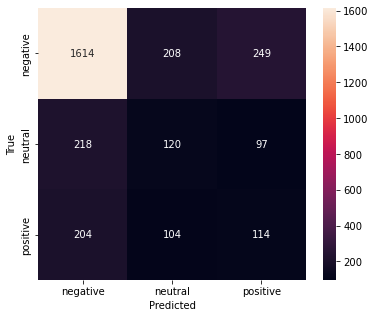

In [27]:
# Test TfidNMF
t_args = {"min_df":0.01,
          "stop_words":'english'}
n_args = {}

TfidNMF().evaluate(trn, ytrn, vld, yvld, t_args, n_args, cm_plot=True)

### 2c.ii) TFID-SVD-Kmeans Model

In [28]:
class TfidKmeans:
    def __init__(self):
        self.vec = None # Tfid model
        self.svd = None # NMF model
        self.kmn = None # Kmeans model
        self.label_order = None
    
    def fit(self, train, ytrain, tfid_args, svd_args, kmn_args, random_state=7):
        self.vec = TfidfVectorizer(**tfid_args)
        
        if "random_state" not in svd_args:
            svd_args["random_state"]=random_state
        self.svd = TruncatedSVD(**svd_args)
        
        if "n_clusters" not in kmn_args:
            kmn_args["n_clusters"] = label_count
        if "random_state" not in kmn_args:
            kmn_args["random_state"]=random_state        
        self.kmn = KMeans(**kmn_args)
        
        Xtrain = self.vec.fit_transform(train)
        reduced = self.svd.fit_transform(Xtrain)
        self.kmn.fit(reduced)
        self.label_order = set_label_order(self.transform(train), ytrain)
    
    def transform(self, input):
        Xinput = self.vec.transform(input)
        Xred = self.svd.transform(Xinput)
        grouped = pd.DataFrame(self.kmn.transform(Xred)).idxmax(axis=1)
        grouped.index=input.index
        return grouped
    
    def evaluate(self, train, ytrain, test, ytest, tfid_args, svd_args, kmn_args, 
                 f1_average="weighted", cm_plot=False, random_state=7):
        t0 = time.time()
        self.fit(train, ytrain, tfid_args, svd_args, kmn_args)
        pred_test = get_labels(self.transform(test), self.label_order)
        runtime = time.time()-t0

        score = diagnostic(pred_test, ytest, f1_average, cm_plot)
        return score, runtime, self       

(0.615215353124164, 0.4608726501464844, <__main__.TfidKmeans at 0x1dd70e8a640>)

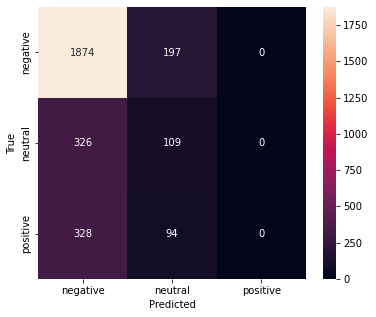

In [29]:
# Test TfidKMeans
t_args = {"min_df":0.01,
          "stop_words":'english'}
s_args = {"n_components":30}
k_args = {}

TfidKmeans().evaluate(trn, ytrn, vld, yvld, t_args, s_args, k_args, cm_plot=True)

### 2c.iii) TFID-SVD-GaussianMixture Model

In [30]:
class TfidGauss:
    def __init__(self):
        self.vec = None # Tfid model
        self.svd = None # NMF model
        self.gmx = None # GaussiasMixture model
        self.label_order = None
    
    def fit(self, train, ytrain, tfid_args, svd_args, gmx_args, random_state=7):
        self.vec = TfidfVectorizer(**tfid_args)
        
        if "random_state" not in svd_args:
            svd_args["random_state"]=random_state
        self.svd = TruncatedSVD(**svd_args)
        
        if "n_components" not in gmx_args:
            gmx_args["n_components"] = label_count
        if "random_state" not in gmx_args:
            gmx_args["random_state"]=random_state        
        self.gmx = GaussianMixture(**gmx_args)
        
        Xtrain = self.vec.fit_transform(train)
        reduced = self.svd.fit_transform(Xtrain)
        self.gmx.fit(reduced)
        self.label_order = set_label_order(self.transform(train), ytrain)
    
    def transform(self, input):
        Xinput = self.vec.transform(input)
        Xred = self.svd.transform(Xinput)
        grouped = pd.Series(self.gmx.predict(Xred))
        grouped.index=input.index
        return grouped
    
    def evaluate(self, train, ytrain, test, ytest, tfid_args, svd_args, gmx_args, 
                 f1_average="weighted", cm_plot=False, random_state=7):
        t0 = time.time()
        self.fit(train, ytrain, tfid_args, svd_args, gmx_args)
        pred_test = get_labels(self.transform(test), self.label_order)
        runtime = time.time()-t0

        score = diagnostic(pred_test, ytest, f1_average, cm_plot)
        return score, runtime, self       

(0.4897575152424722, 0.8264875411987305, <__main__.TfidGauss at 0x1dd7255b9a0>)

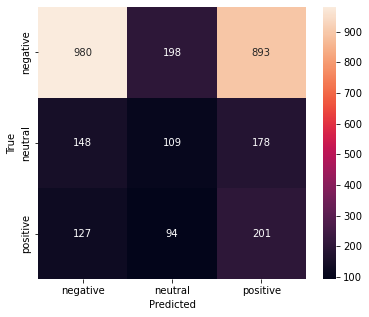

In [31]:
# Test TfidGauss
t_args = {"min_df":0.01,
          "stop_words":'english'}
s_args = {"n_components":30}
g_args = {}

TfidGauss().evaluate(trn, ytrn, vld, yvld, t_args, s_args, g_args, cm_plot=True)

# 3) Hyperparameter Tuning

This tuning will be non-exhaustive

### Tuning Tfid
Of the parameters we can control in out Tfid model, we will look at stop words, removing terms that are too common, length of n-grams included, and output normalization.

### 3a) Tuning NMF-based model
After establishing ballpark parameter values for the Tfid, we will primarily control the solver and loss function of the NMF model.

In [32]:
def tNMFgrid(arg_dic1, param1, range1, arg_dic2, param2, range2, 
               train=trn, ytrain=ytrn, validation=vld, yvalidation=yvld):
    best_score = 0
    best_pair = None

    for i in range1:
        arg_dic1[param1] = i
        for j in range2:
            arg_dic2[param2] = j
            result = TfidNMF().evaluate(trn, ytrn, vld, yvld, t_args, n_args)
            if result[0] > best_score:
                best_score = result[0]
                best_pair = (i,j)
    print(f"best score: {best_score} with {param1}:{best_pair[0]} and {param2}:{best_pair[1]}")

In [33]:
t_args = {'ngram_range':(1,1)}
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003, 0.03], 
         t_args, 'max_df', [1.0, 0.95, 0.85])

best score: 0.6690539533534449 with min_df:0.001 and max_df:1.0


> With only unigrams, we're seeing the best performance with the inclusion of all ngrams. The F1 score here is an improvement over the English stopwords settings (~0.63).

In [34]:
t_args = {'ngram_range':(1,2)}
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003, 0.03], 
         t_args, 'max_df', [1.0, 0.95, 0.85])

best score: 0.6856130014759958 with min_df:0.001 and max_df:1.0


> Improvement with the addition of bigrams. Note that it hasn't affected the "best" Tfid parameters

In [35]:
t_args = {'ngram_range':(1,3)}
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003], 
         t_args, 'max_df', [1.0, 0.95, 0.85])

best score: 0.6908835991718708 with min_df:1 and max_df:1.0


> Further improvement with tri-grams. The best *min_df* was at 1 (int) rather than 0.001 of the dataset, but these aren't too far apart.

In [36]:
t_args = {'ngram_range':(1,4)}
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003], 
         t_args, 'max_df', [1.0, 0.95, 0.85])

best score: 0.6886327734331568 with min_df:1 and max_df:1.0


> We likely peaked at (1,3) for the *ngram_range*

We'll close in to see if we can get more precise values for the parameters.

In [37]:
t_args = {'ngram_range':(1,3)}
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003], 
         t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6908835991718708 with min_df:1 and max_df:1.0


In [38]:
t_args = {'ngram_range':(1,3), 
          'norm':'l1'} # default is 'l2' 
n_args = {'init':'nndsvd'}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003], 
         t_args, 'max_df', [1.0, 0.98, 0.95])

best score: 0.6499359991976141 with min_df:0.003 and max_df:1.0


> The non-default normalization wasn't an improvement.

We'll move on now to modifying the **NMF parameters**.

In [39]:
t_args = {'ngram_range':(1,3)}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}

tNMFgrid(t_args, 'min_df', [1, 0.001, 0.003], 
         t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6913326550252961 with min_df:1 and max_df:1.0


> We see an incremental improvement over our previous best!

In [40]:
t_args = {'max_df':1.0}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}

tNMFgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
         t_args, 'min_df', [1, 0.001])

best score: 0.7051621847005198 with ngram_range:(1, 4) and min_df:1


In [41]:
t_args = {'max_df':1.0}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}

tNMFgrid(t_args, 'ngram_range', [(1,5), (1,6)], 
         t_args, 'min_df', [1, 0.001])

best score: 0.7173180198306851 with ngram_range:(1, 5) and min_df:1


In [42]:
t_args = {'ngram_range':(1,5)}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}

tNMFgrid(t_args, 'min_df', [1, 0.001], 
         t_args, 'max_df', [1.0, 0.99])

best score: 0.7173180198306851 with min_df:1 and max_df:1.0


(0.7173180198306851, 10.151506185531616, <__main__.TfidNMF at 0x1dd72c1ca30>)

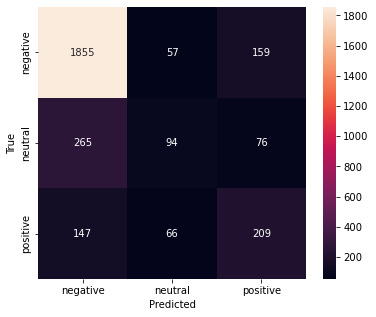

In [43]:
### BEST NMF:
t_args = {'min_df':1,
          'max_df':1.0,
          'ngram_range':(1,5)}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}
TfidNMF().evaluate(trn, ytrn, vld, yvld, t_args, n_args, cm_plot=True)

> The model seems to be doing a decent job of correctly identifying negative tweets, but misidentifying neutral (as True). Positive tweets are more often labeled correctly, but many were mislabeled.

### 3b) Tuning Kmeans-based model
We can again tune the Tfid parameters. As for SVC, we can control how many components our vectorized texts are reduced to, and the algorithm used to solve. For Kmeans, we will try modifying the initialization. 

In [44]:
def tKMgrid(arg_dic1, param1, range1, arg_dic2, param2, range2, 
               train=trn, ytrain=ytrn, validation=vld, yvalidation=yvld):
    best_score = 0
    best_pair = None

    for i in range1:
        arg_dic1[param1] = i
        for j in range2:
            arg_dic2[param2] = j
            result = TfidKmeans().evaluate(trn, ytrn, vld, yvld, t_args, s_args, k_args)
            if result[0] > best_score:
                best_score = result[0]
                best_pair = (i,j)
    print(f"best score: {best_score} with {param1}:{best_pair[0]} and {param2}:{best_pair[1]}")

In [45]:
t_args = {'ngram_range':(1,1)}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        t_args, 'max_df', [1.0, 0.95, 0.85])

best score: 0.6276195866463106 with min_df:1 and max_df:1.0


In [46]:
t_args = {'ngram_range':(1,2)}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6399838446788629 with min_df:0.001 and max_df:1.0


In [47]:
t_args = {'ngram_range':(1,3)}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6395342671593861 with min_df:0.001 and max_df:1.0


In [48]:
t_args = {'ngram_range':(1,4)}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6361103905375564 with min_df:0.001 and max_df:1.0


Try other SVD **n_components** values for ngram_range (1,2):

In [49]:
t_args = {'ngram_range':(1,2),
          'max_df':1.0}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        s_args, 'n_components', [20, 60,100])

best score: 0.6413536816122024 with min_df:0.001 and n_components:60


> Interestingly, we do *not* see an improvement with 100 components vs 60 in the SVD transformation

In [56]:
t_args = {'ngram_range':(1,2),
          'max_df':1.0}
s_args = {'n_components':30}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.002], 
        s_args, 'n_components', [40, 50, 60, 70, 80])

best score: 0.6413536816122024 with min_df:0.001 and n_components:50


Try alternative **SVD algorithm**

In [50]:
t_args = {'ngram_range':(1,2)}
s_args = {'n_components':60,
          'algorithm':'arpack'}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001, 0.003], 
        t_args, 'max_df', [1.0, 0.99, 0.98])

best score: 0.6402088021558583 with min_df:0.001 and max_df:1.0


In [54]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
k_args = {}

tKMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [30, 60, 100])

best score: 0.6415224635241492 with ngram_range:(1, 3) and n_components:100


In [57]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
k_args = {}

tKMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [130, 160, 200, 250, 350])

best score: 0.642464636382732 with ngram_range:(1, 2) and n_components:250


In [59]:
t_args = {'ngram_range':(1,2),
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001], 
        s_args, 'n_components', [240, 250, 260, 270])

best score: 0.642464636382732 with min_df:0.001 and n_components:250


See effect of **Kmeans initialization**:

In [60]:
t_args = {'ngram_range':(1,2),
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
k_args = {'init':'random'}

tKMgrid(t_args, 'min_df', [1, 0.001], 
        s_args, 'n_components', [240, 250, 260])

best score: 0.6416080134731444 with min_df:0.001 and n_components:240


> random initialization hasn't improved performance with this set of parameters

Narrowing things down:

In [62]:
t_args = {'ngram_range':(1,2),
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
k_args = {}

tKMgrid(t_args, 'min_df', [1, 0.001], 
        s_args, 'n_components', [246, 247, 248, 249, 250, 251])

best score: 0.642464636382732 with min_df:0.001 and n_components:248


(0.642464636382732, 3.514698028564453, <__main__.TfidKmeans at 0x1dd70f256a0>)

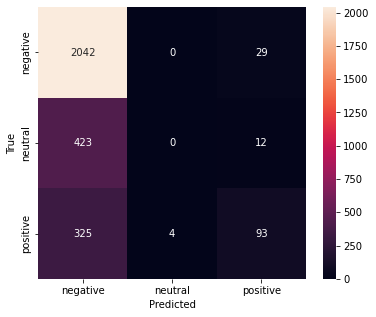

In [64]:
### BEST Kmeans:
t_args = {'min_df':0.001,
          'max_df':1.0,
          'ngram_range':(1,2)}
s_args = {'algorithm':'arpack',
          'n_components':248}
k_args = {}
TfidKmeans().evaluate(trn, ytrn, vld, yvld, t_args, s_args, k_args, cm_plot=True)

> This model performs worse than the best NMF model. It is strongly skewing towards negative labels, almost completely avoiding neutral labels.

### 3c) Tuning GaussianMixture-based model
For the GaussianMixture model, we will try adjusting the initialization (as we did for Kmeans) as well as covariance_type

In [65]:
def tGMgrid(arg_dic1, param1, range1, arg_dic2, param2, range2, 
               train=trn, ytrain=ytrn, validation=vld, yvalidation=yvld):
    best_score = 0
    best_pair = None

    for i in range1:
        arg_dic1[param1] = i
        for j in range2:
            arg_dic2[param2] = j
            result = TfidGauss().evaluate(trn, ytrn, vld, yvld, t_args, s_args, g_args)
            if result[0] > best_score:
                best_score = result[0]
                best_pair = (i,j)
    print(f"best score: {best_score} with {param1}:{best_pair[0]} and {param2}:{best_pair[1]}")

In [68]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3)], 
        s_args, 'n_components', [50, 100, 250])

best score: 0.6399456835837383 with ngram_range:(1, 2) and n_components:250


> this early result suggests this model may have similar parameter sensitivities as the Kmeans

In [70]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {}
g_args = {}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [50, 100, 250])

best score: 0.6241560050870003 with ngram_range:(1, 4) and n_components:250


In [72]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {}
g_args = {}

tGMgrid(t_args, 'ngram_range', [(1,3), (1,4), (1,5)], 
        s_args, 'n_components', [250, 270, 300])

best score: 0.6264065883567537 with ngram_range:(1, 5) and n_components:270


> We haven't surpassed the performance with arpack, so we will return to that algorithm

Now to adjust **GaussianMixture covariance_type**:

In [76]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'tied'}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [200, 250, 300])

best score: 0.6428453923914619 with ngram_range:(1, 3) and n_components:250


In [77]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'diag'}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [200, 250, 300])

best score: 0.5560530666130044 with ngram_range:(1, 2) and n_components:300


In [78]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical'}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [200, 250, 300])

best score: 0.6527401191118014 with ngram_range:(1, 3) and n_components:250


Try **random initialization**:

In [79]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,2), (1,3), (1,4)], 
        s_args, 'n_components', [200, 250, 300])

best score: 0.6615605931513042 with ngram_range:(1, 4) and n_components:300


In [80]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,3), (1,4), (1,5)], 
        s_args, 'n_components', [290, 300, 310, 350])

best score: 0.677766992089116 with ngram_range:(1, 5) and n_components:350


> This model seems be responding to more higher Tfid and SVD dimensions

In [82]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,5), (1,6), (1,7)], 
        s_args, 'n_components', [350, 370, 400])

best score: 0.6871619348053293 with ngram_range:(1, 6) and n_components:400


In [83]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,5), (1,6), (1,7)], 
        s_args, 'n_components', [450, 500])

best score: 0.6942272485505848 with ngram_range:(1, 7) and n_components:450


In [84]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,6), (1,7), (1,8)], 
        s_args, 'n_components', [450, 500, 600])

best score: 0.6942272485505848 with ngram_range:(1, 7) and n_components:450


In [85]:
t_args = {'min_df':0.001,
          'max_df':1.0}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}

tGMgrid(t_args, 'ngram_range', [(1,6), (1,7), (1,8)], 
        s_args, 'n_components', [300, 350, 400])

best score: 0.6871619348053293 with ngram_range:(1, 6) and n_components:400


In [88]:
t_args = {'min_df':0.001,
          'max_df':1.0,
          'ngram_range':(1,7)}
s_args = {'algorithm':'arpack'}
g_args = {'covariance_type':'spherical'}

tGMgrid(s_args, 'n_components', [448, 449, 450, 451, 452], 
        g_args, 'init_params', ['random','kmeans'])

best score: 0.6942272485505848 with n_components:450 and init_params:random


(0.6942272485505848, 15.325878143310547, <__main__.TfidGauss at 0x1dd71a3ba60>)

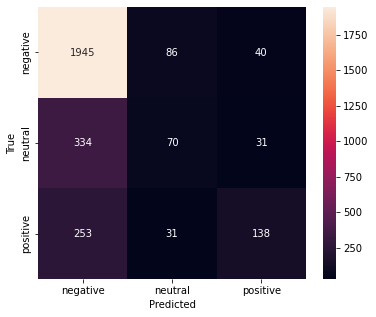

In [89]:
### BEST Gaussian:
t_args = {'min_df':0.001,
          'max_df':1.0,
          'ngram_range':(1,7)}
s_args = {'algorithm':'arpack',
          'n_components': 450}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}
TfidGauss().evaluate(trn, ytrn, vld, yvld, t_args, s_args, g_args, cm_plot=True)

> The model seems to be doing a decent job of correctly identifying negative tweets, but misidentifying neutral (as True). Positive tweets are more often labeled correctly, but many were mislabeled.

# 4) Comparisons & Conclusions
We will retrain our best models on the combined training and validation sets and test them against the test set.

(0.7008715429171295, 19.150943517684937, <__main__.TfidNMF at 0x1dd71a3b5b0>)

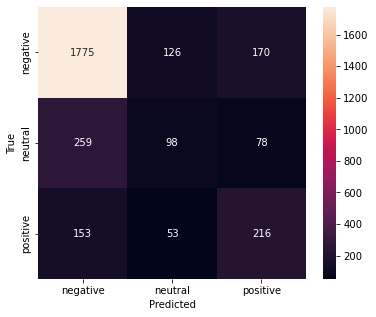

In [90]:
### BEST NMF:
t_args = {'min_df':1,
          'max_df':1.0,
          'ngram_range':(1,5)}
n_args = {'init':'nndsvda', # changed to work with 'mu' solver
          'solver':'mu', # changed to work with k-l loss
          'beta_loss': 'kullback-leibler',}
TfidNMF().evaluate(non_test, ynon_test, tst, ytst, t_args, n_args, cm_plot=True)

(0.6244363622841833, 5.258326768875122, <__main__.TfidKmeans at 0x1dd0cb0f8b0>)

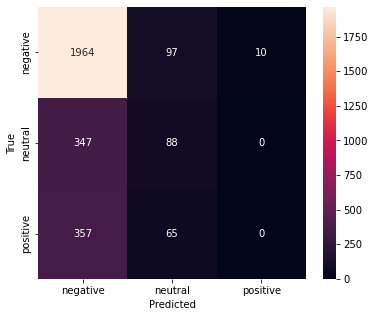

In [91]:
### BEST Kmeans:
t_args = {'min_df':0.001,
          'max_df':1.0,
          'ngram_range':(1,2)}
s_args = {'algorithm':'arpack',
          'n_components':248}
k_args = {}
TfidKmeans().evaluate(non_test, ynon_test, tst, ytst, t_args, s_args, k_args, cm_plot=True)

(0.6435916811362665, 13.68778944015503, <__main__.TfidGauss at 0x1dd0d2a2b20>)

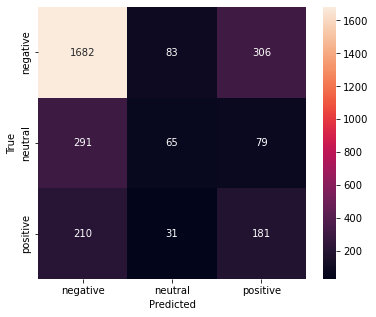

In [92]:
### BEST Gaussian:
t_args = {'min_df':0.001,
          'max_df':1.0,
          'ngram_range':(1,7)}
s_args = {'algorithm':'arpack',
          'n_components': 450}
g_args = {'covariance_type':'spherical',
          'init_params':'random'}
TfidGauss().evaluate(non_test, ynon_test, tst, ytst, t_args, s_args, g_args, cm_plot=True)

### Conclusion
The NMF model performed best on the test set.

All three models suffered from a bias to over-predict negative labels on the test set. In fact, in all cases except NMF labeling positive data, the models mislabeled non-negative tweets more than they correctly labeled them.

It seems possible (likely?) that unsupervised methods are not the best tool for this task. We haven't attempted any supervised techniques here (outside the focus of this class), but some of the discussion on Kaggle suggests people have achieved 90% accuracy using supervised techniques.